# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 25-11-2021 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian

sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Options for the program: 

In [2]:
blinded = True            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Functions:

A Gaussian PDF (unit integral):

In [3]:
# Define your PDF / model: 
def gauss_pdf(x, N, mu, sigma):
    """Gaussian"""
    return N / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [4]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [5]:
infiles = ["data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files:

In [6]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total
print(L30cm)
print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")

[3.40367142 3.40967142 3.39967142 3.41567142 3.40667142 3.41267142
 3.41667142 3.40367142 3.41167142 3.41367142 3.40467142 3.41767142
 3.42567142 3.40467142 3.28067142 3.54967142 3.42567142 3.38267142
 3.48667142 3.40267142 3.10567142 3.40467142 3.40467142 3.41767142
 3.71267142 3.10467142 3.40767142 3.40467142 3.13167142 3.49267142
 3.41467142 3.16767142 3.38967142 3.39967142 3.41667142 3.37967142
 2.20567142 3.09367142 3.38767142 3.41467142 3.08467142 3.31967142
 3.40967142 3.41067142 3.10567142 3.42367142 3.40067142 3.10967142
 2.86367142 3.41067142 3.41767142 3.39767142 3.40967142 3.41167142
 3.41767142 3.71667142 3.40167142 4.00867142 3.41667142 3.41567142
 3.40067142 3.41067142 3.41767142 1.43367142 3.32467142 3.39967142
 3.34867142 3.41867142 3.70467142 3.39967142 3.41267142 3.41867142
 3.40467142 3.41167142 3.44967142 3.40367142 3.40967142 3.40367142
 3.52267142 3.42267142 3.39967142 3.70367142 3.45667142 3.41667142
 3.41467142 3.41567142 3.37467142 3.89067142 3.41867142 3.2496

### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


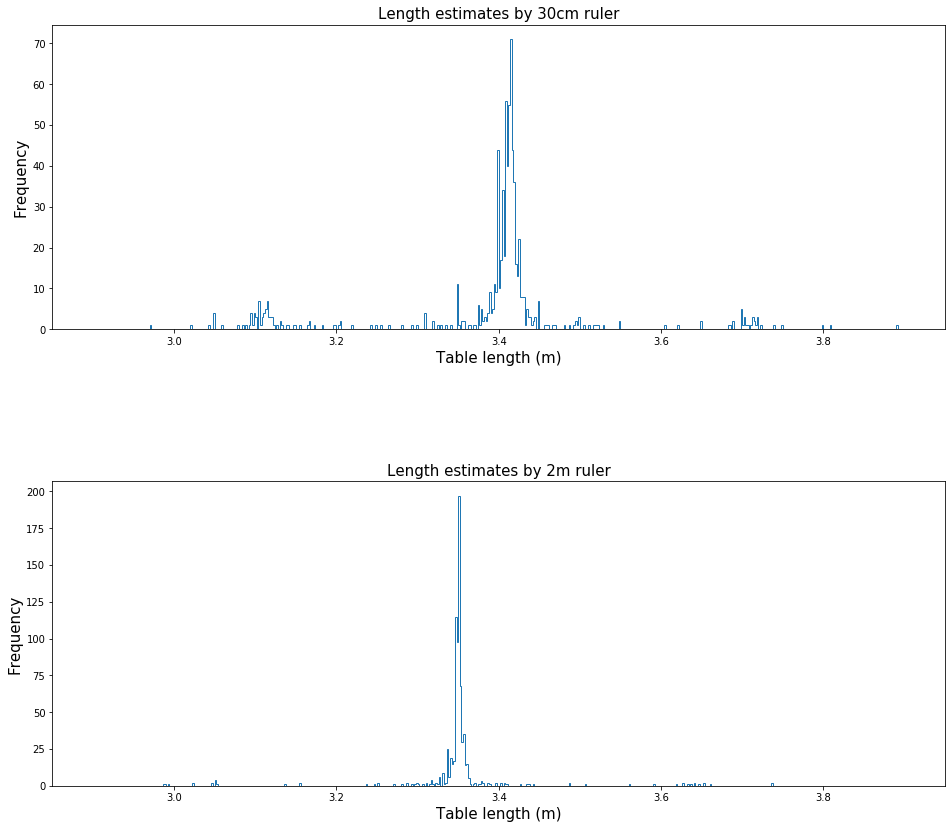

In [7]:
# Carefully consider binning - this might have to be changed, and subplots are defintely worth considering!
Nbins = 500
minL = 2.9
maxL = 3.9
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

fig_raw.tight_layout()

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and RMS calculation along with a general Gaussian fit to all the data. Somehow, the Standard Deviation (Std) doesn't seem optimal/right...  

In [8]:
print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")

  Initial estimate of raw data (30 cm ruler):  3.376 +- 0.008 m     (Std = 0.215)


### Fitting the data:
Then we set up an __unbinned likelihood fit__, and fit the full data set:

In [9]:
ullh_L30cm = UnbinnedLH(gauss_pdf, L30cm, extended=True)
minuit_L30cm = Minuit(ullh_L30cm, N=len(L30cm)*binwidth, mu=L30cm.mean(), sigma=L30cm.std(ddof=1))
minuit_L30cm.print_level = 1
minuit_L30cm.errordef = 0.5
minuit_L30cm.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4541                      │              Nfcn = 130              │
│ EDM = 7.99e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    785    │    28     │            │            │         │         │       │
│ 1 │ mu    │   3.376   │   0.008   │            │            │         │         │       │
│ 2 │ sigma │   0.215   │   0.005   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        N       mu    sigma │
├───────┼────────────────────────────┤
│     N │      785 6.87e-06  1.5e-05 │
│    mu │ 6.87e-06 5.88e-05 6.77e-08 │
│ sigma │  1.5e-05 6.77e-08 2.94e-05 │
└───────┴────────────────────────────┘

In [10]:
# The fitted values of the parameters and their uncertainties:
L30cm_fit_mu = minuit_L30cm.values["mu"]
L30cm_fit_mu_error = minuit_L30cm.errors["mu"]
L30cm_fit_sigma = minuit_L30cm.values["sigma"]
print(f"  The unbinned LH fitted estimate (30cm ruler): {L30cm_fit_mu:.3f} +- {L30cm_fit_mu_error:.3f} m     RMS = {L30cm_fit_sigma:.3f}")

  The unbinned LH fitted estimate (30cm ruler): 3.376 +- 0.008 m     RMS = 0.215


### Note on fit result:

Surprised to see the same numbers come out of the unbinned likelihood fit as those of the mean, standard deviation, and uncertainty on the mean?

Well, the reason for this is, that the calculation of these three quantities can actually be *derived* from the principle of maximum likelihood (see Barlow 5.2.1 and 5.2.2).

### Plotting:

Now we plot the fit on the figure:

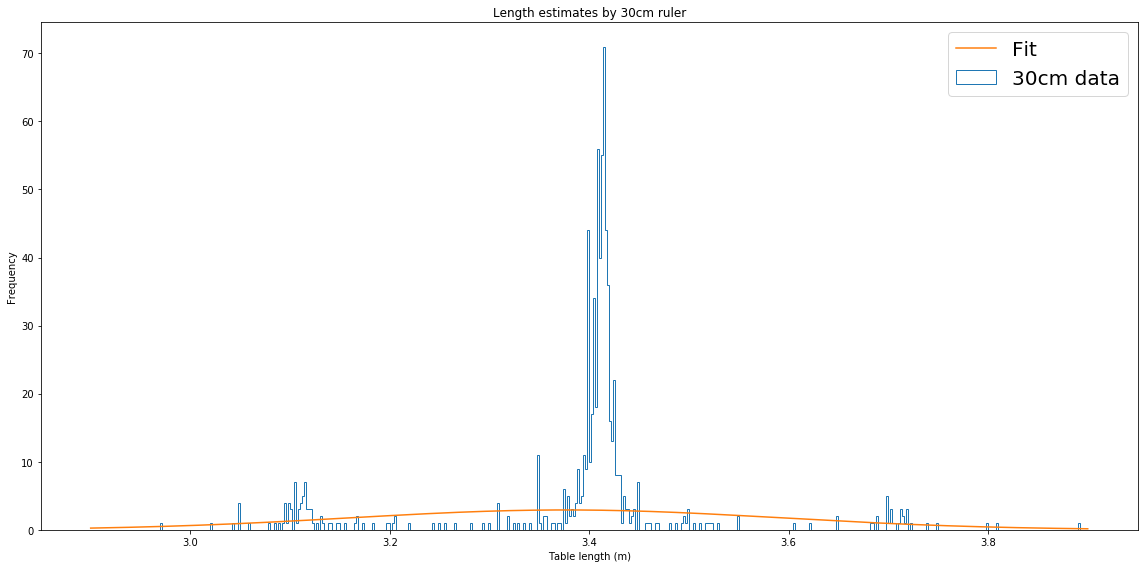

In [11]:
# Create the x-axis for the plot of the fitted function, and ompute the fitted function for x_fit:
xaxis = np.linspace(minL, maxL, 10000) 
yaxis = gauss_pdf(xaxis, len(L30cm)*binwidth, L30cm_fit_mu, L30cm_fit_sigma) 

# Plot the fit together with the data:
fig_fitL30cm, ax_fitL30cm = plt.subplots(figsize=(16,8))
hist_fitL30cm = ax_fitL30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_fitL30cm.set(title='Length estimates by 30cm ruler', xlabel='Table length (m)', ylabel='Frequency')
ax_fitL30cm.plot(xaxis, yaxis, '-', label='Fit')
ax_fitL30cm.legend(fontsize=20)

fig_fitL30cm.tight_layout()

### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement. It is now up to you to select in (based on solid **quantified** arguments) and/or correct the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

In [12]:
# Clean up in the data:
L30cm = np.sort(L30cm)

# For your data analysis, you can consider either throwing away measurements or correcting them.
# This is question 2 below.
mask = (L30cm >= -100.0) * (L30cm <= 100.0)      # Write your own data selection!!!

# But remember, you should be able to argue for each an every point you remove or correct.
# In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case!
# Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines

L30cm_subset = L30cm[mask]
print(f"  The number of measurements used before and after is: {len(L30cm):d} and {len(L30cm_subset):d}")

  The number of measurements used before and after is: 785 and 785


***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yeps, open the damn thing, and look over the numbers!), and then by considering the histograms produced by running the notebook. To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.

When you're done, please fill in your results here:
https://docs.google.com/forms/d/1n4EJmd-3FO5Pi8CjJw-lAw_aEs4SWSXx4_th7NJMhaA/ (anonymous).
The purpose is to see, how large variation one can get in answers, even when asking the same data the same questions.


# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

4. Once you have selected the measurements you want to use, calculate the mean, standard deviation, and uncertainty on the mean. How much did your result improve in precision from the raw data in question 1?

5. Now consider also the uncertainties. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Or are some measurements and/or uncertainties doubtful?

6. In order to consider measurements in light of the uncertainties, the "Pull" distribution is defined as the plot of $z_i = \left(x_i - \overline{x} \right)/\sigma_i$ where $\overline{x}$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties. Did the Chi2 probablity improve? And did the result improve further in precision? If not, why could that be?

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{mis} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)


### Advanced questions:

11. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?